<a href="https://colab.research.google.com/github/ImagingDataCommons/IDC-Tutorials/blob/master/notebooks/advanced_topics/gcs_aws_direct_access.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Directly loading DICOM objects from Google Cloud or AWS in Python

This notebook accompanies this documentation article for NCI Imaging Data Commons: https://learn.canceridc.dev/data/downloading-data/direct-loading, which describes how one can access individual tags or frames within DICOM objects/images without retrieving the entire DICOM file.

The notebook simply replicates the content of the code cells from the documentation article above for convenience. Do read the actual article for details!

Questions? Ask those at the IDC forum here: https://discourse.canceridc.dev.

---

Created: May 2025

# Prerequisites

In [1]:
%%capture
!pip install --upgrade idc-index highdicom

In [2]:
%%capture
!pip install boto3 smart-open

## Mapping IDC DICOM series to bucket URLs



In [3]:
from idc_index import IDCClient


# Create IDCClient for looking up bucket URLs
idc_client = IDCClient()

# Get the list of GCS file URLs in Google bucket from SeriesInstanceUID
gcs_file_urls = idc_client.get_series_file_URLs(
    seriesInstanceUID="1.3.6.1.4.1.14519.5.2.1.131619305319442714547556255525285829796",
    source_bucket_location="gcs",
)

# Get the list of AWS file URLs in AWS bucket from SeriesInstanceUID
aws_file_urls = idc_client.get_series_file_URLs(
    seriesInstanceUID="1.3.6.1.4.1.14519.5.2.1.131619305319442714547556255525285829796",
    source_bucket_location="aws",
)

## Reading from GCS blobs

In [4]:
from pydicom import dcmread
from pydicom.datadict import keyword_dict
from google.cloud import storage
from idc_index import IDCClient


# Create IDCClient for looking up bucket URLs
idc_client = IDCClient()

# Create a client and bucket object representing the IDC public data bucket
gcs_client = storage.Client.create_anonymous_client()

# This example uses a CT series in the IDC.
# get the list of file URLs in Google bucket from the SeriesInstanceUID
file_urls = idc_client.get_series_file_URLs(
    seriesInstanceUID="1.3.6.1.4.1.14519.5.2.1.131619305319442714547556255525285829796",
    source_bucket_location="gcs",
)

# URLs will look like this:
# s3://idc-open-data/668029cf-41bf-4644-b68a-46b8fa99c3bc/f4fe9671-0a99-4b6d-9641-d441f13620d4.dcm
(_, _, bucket_name, folder_name, file_name) = file_urls[0].split("/")
blob_key = f"{folder_name}/{file_name}"

# These objects represent the bucket and a single image blob within the bucket
bucket = gcs_client.bucket(bucket_name)
blob = bucket.blob(blob_key)

# Read the whole file directly from the blob
with blob.open("rb") as reader:
    dcm = dcmread(reader)

# Read metadata only (no pixel data)
with blob.open("rb") as reader:
    dcm = dcmread(reader, stop_before_pixels=True)

# Read only specific attributes, identified by their tag
# (here the Manufacturer and ManufacturerModelName attributes)
with blob.open("rb") as reader:
    dcm = dcmread(
        reader,
        specific_tags=[keyword_dict['Manufacturer'], keyword_dict['ManufacturerModelName']],
    )
    print(dcm)

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 204
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.96396497662242566847362732927681121010
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002,0013) Implementation Version Name         SH: '0.5'
(0002,0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0070) Manufacturer                        LO: 'TOSHIBA'
(0008,1090) Manufacturer's Model Name           LO: 'Asteion'


### From AWS blobs

In [5]:
from io import BytesIO
from pydicom import dcmread

import boto3
from botocore import UNSIGNED
from botocore.config import Config
from idc_index import IDCClient


# Create IDCClient for looking up bucket URLs
idc_client = IDCClient()

# This example uses a CT series in the IDC (same as above).
# Get the list of file URLs in AWS bucket from SeriesInstanceUID
file_urls = idc_client.get_series_file_URLs(
    seriesInstanceUID="1.3.6.1.4.1.14519.5.2.1.131619305319442714547556255525285829796",
    source_bucket_location="aws",
)

# URLs will look like this:
# s3://idc-open-data/668029cf-41bf-4644-b68a-46b8fa99c3bc/f4fe9671-0a99-4b6d-9641-d441f13620d4.dcm
(_, _, bucket_name, folder_name, file_name) = file_urls[0].split("/")
blob_key = f"{folder_name}/{file_name}"

# Configure a client to avoid the need for AWS credentials
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

with BytesIO() as buf:
    # Download entire file contents to an in-memory buffer
    s3_client.download_fileobj("idc-open-data", blob_key, buf)

    # Use pydicom to read from the in-memory buffer
    buf.seek(0)
    dcm = dcmread(buf)

In [6]:
from pydicom import dcmread

import boto3
from botocore import UNSIGNED
from botocore.config import Config
import smart_open

from idc_index import IDCClient

# Create IDCClient for looking up bucket URLs
idc_client = IDCClient()

# Get the list of file URLs in AWS bucket from SeriesInstanceUID
file_urls = idc_client.get_series_file_URLs(
    seriesInstanceUID="1.3.6.1.4.1.14519.5.2.1.131619305319442714547556255525285829796",
    source_bucket_location="aws"
)

# URL to an IDC CT image on AWS S3
url = file_urls[0]

# Configure a client to avoid the need for AWS credentials
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

# Read the whole file directly from the blob
with smart_open.open(url, mode="rb", transport_params=dict(client=s3_client)) as reader:
    dcm = dcmread(reader)

# Read metadata only (no pixel data)
with smart_open.open(url, mode="rb", transport_params=dict(client=s3_client)) as reader:
    dcm = dcmread(reader, stop_before_pixels=True)

## Frame-level access with highdicom

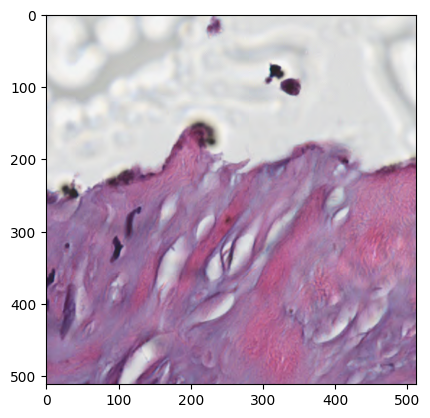

In [7]:
import numpy as np
import highdicom as hd
import matplotlib.pyplot as plt
from google.cloud import storage
from pydicom import dcmread
from pydicom.datadict import keyword_dict

from idc_index import IDCClient

# Create IDCClient for looking up bucket URLs
idc_client = IDCClient()

# install additional component of idc-index to resolve SM instances to file URLs
idc_client.fetch_index("sm_instance_index")

# given SeriesInstanceUID of an SM series, find the instance that corresponds to the
# highest resolution base layer of the image pyramid
query = """
SELECT SOPInstanceUID, TotalPixelMatrixColumns
FROM sm_instance_index
WHERE SeriesInstanceUID = '1.3.6.1.4.1.5962.99.1.1900325859.924065538.1719887277027.4.0'
ORDER BY TotalPixelMatrixColumns DESC
LIMIT 1
"""
result = idc_client.sql_query(query)

# get URL corresponding to the base layer instance in the Google Storage bucket
base_layer_file_url = idc_client.get_instance_file_URL(sopInstanceUID=result.iloc[0]["SOPInstanceUID"], source_bucket_location="gcs")

# Create a storage client and use it to access the IDC's public data package
gcs_client = storage.Client.create_anonymous_client()

(_,_, bucket_name, folder_name, file_name) = base_layer_file_url.split("/")
blob_key = f"{folder_name}/{file_name}"

bucket = gcs_client.bucket(bucket_name)
base_layer_blob = bucket.blob(blob_key)

# Read directly from the blob object using lazy frame retrieval
with base_layer_blob.open(mode="rb") as reader:
    im = hd.imread(reader, lazy_frame_retrieval=True)

    # Grab an arbitrary region of tile full pixel matrix
    region = im.get_total_pixel_matrix(
        row_start=15000,
        row_end=15512,
        column_start=17000,
        column_end=17512,
        dtype=np.uint8
    )

# Show the region
plt.imshow(region)
plt.show()

In [8]:
import highdicom as hd
from google.cloud import storage
from idc_index import IDCClient


# Create IDCClient for looking up bucket URLs
idc_client = IDCClient()

# Get the file URL corresponding to the segmentation of a CT series
# containing a large number of different organs - the same one as used in the
# IDC Portal front page
file_urls = idc_client.get_series_file_URLs(
    seriesInstanceUID="1.2.276.0.7230010.3.1.3.313263360.15787.1706310178.804490",
    source_bucket_location="gcs"
)

(_, _, bucket_name, folder_name, file_name) = file_urls[0].split("/")

# Create a storage client and use it to access the IDC's public data package
gcs_client = storage.Client.create_anonymous_client()
bucket = gcs_client.bucket(bucket_name)

blob_name = f"{folder_name}/{file_name}"
blob = bucket.blob(blob_name)

# Open the blob with "segread" using the "lazy frame retrieval" option
with blob.open(mode="rb") as reader:
    seg = hd.seg.segread(reader, lazy_frame_retrieval=True)

    # Find the segment number corresponding to the liver segment
    selected_segment_numbers = seg.get_segment_numbers(segment_label="Liver")

    # Read in the selected segments lazily
    volume = seg.get_volume(
        segment_numbers=selected_segment_numbers,
        combine_segments=True,
    )

# Print dimensions of the liver segment volume
print(volume.shape)

(162, 512, 512)


### Segmentation access

In [ ]:
import highdicom as hd
from google.cloud import storage
from idc_index import IDCClient


# Create IDCClient for looking up bucket URLs
idc_client = IDCClient()

# Get the file URL corresponding to the segmentation of a CT series
# containing a large number of different organs - the same one as used in the
# IDC Portal front page
file_urls = idc_client.get_series_file_URLs(
    seriesInstanceUID="1.2.276.0.7230010.3.1.3.313263360.15787.1706310178.804490",
    source_bucket_location="gcs"
)

(_, _, bucket_name, folder_name, file_name) = file_urls[0].split("/")

# Create a storage client and use it to access the IDC's public data package
gcs_client = storage.Client.create_anonymous_client()
bucket = gcs_client.bucket(bucket_name)

blob_name = f"{folder_name}/{file_name}"
blob = bucket.blob(blob_name)

# Open the blob with "segread" using the "lazy frame retrieval" option
with blob.open(mode="rb") as reader:
    seg = hd.seg.segread(reader, lazy_frame_retrieval=True)

    # Find the segment number corresponding to the liver segment
    selected_segment_numbers = seg.get_segment_numbers(segment_label="Liver")

    # Read in the selected segments lazily
    volume = seg.get_volume(
        segment_numbers=selected_segment_numbers,
        combine_segments=True,
    )

# Print dimensions of the liver segment volume
print(volume.shape)

(162, 512, 512)


In [ ]:
import pydicom


dcm = pydicom.dcmread("...")  # Any method to read from file/cloud storage


print("Has Extended Offset Table:", "ExtendedOffsetTable" in dcm)
print("Has Basic Offset Table:", dcm.Pixeldata[4:8] != b'\x00\x00\x00\x00')
